In [ ]:
!pip install -q kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pythondevelopersr","key":"0d2d548e736e101512e38dd4a7124f33"}'}

In [2]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Copy the pneumonia data set locally.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 45.5MB/s]
100% 2.29G/2.29G [00:20<00:00, 120MB/s] 


In [4]:
# Create directories
!mkdir -p data/input
!mkdir -p data/output

In [5]:
!unzip -d data/input chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/input/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: data/input/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: data/input/chest_xray/train

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import cv2
# Imports
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import backend as K
from sklearn.metrics import classification_report

import os
import random
import time
import re
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import gc
import pathlib


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [7]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            pathlib.Path(directory_path).mkdir(parents=True, exist_ok=True)
            # os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            pathlib.Path(directory_path).mkdir(parents=True, exist_ok=True)
            # os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

In [8]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

In [9]:
def get_reset_subplot_params(nrows, ncols, dpi):    
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

In [10]:
def select_image_by_category(image_dir, image_count_per_category):    
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [11]:
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [12]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/chest_xray/"
output_directory = r"data/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"

figure_directory = r"data/output/figures"

figure_directory = "data/output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

Number of Class:  2
-------------------------------------------------------Normal-------------------------------------------------------


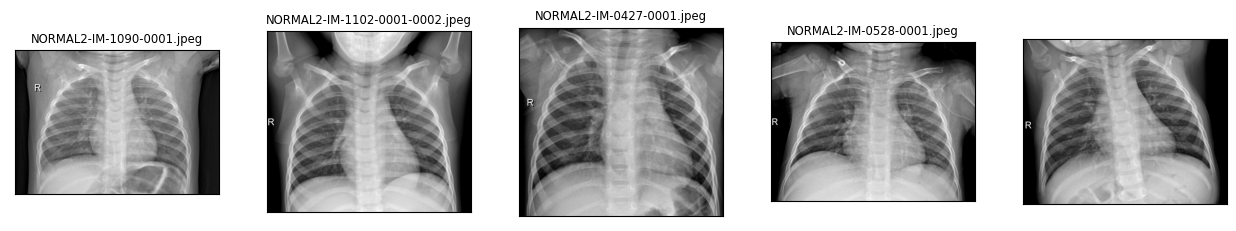


-------------------------------------------------------Pneumonia-------------------------------------------------------


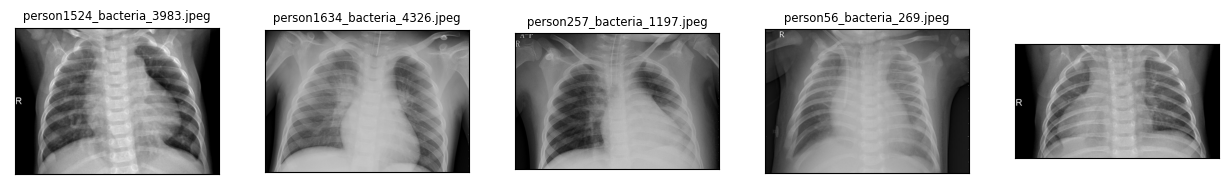


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [13]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

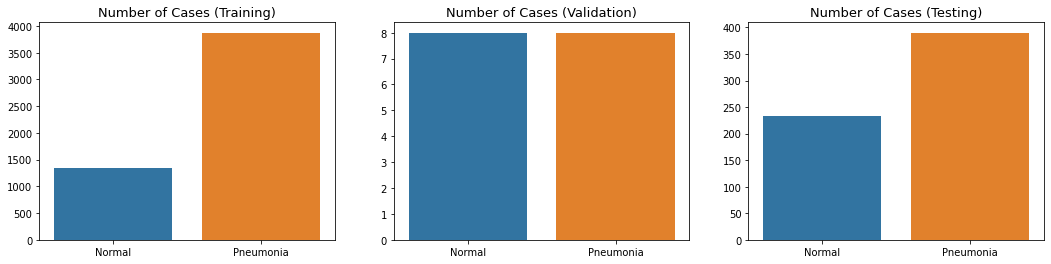

In [14]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

In [16]:
img_dimensions = 150
batch_size = 64

In [17]:

input_path = 'data/input/chest_xray/'
train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(directory=input_path+'train',
target_size = (img_dimensions, img_dimensions),
batch_size = batch_size,
class_mode = 'binary')
test_set = test_datagen.flow_from_directory(directory=input_path+'test',
target_size = (img_dimensions, img_dimensions),
batch_size = batch_size,
class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (img_dimensions, img_dimensions, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [19]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
epochs = 10

history = model.fit_generator(training_set, steps_per_epoch=training_set.samples // batch_size, epochs=epochs, validation_data=test_set,validation_steps= test_set.samples)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/21
81/81 [==============================] - 159s 2s/step - loss: 0.1236 - accuracy: 0.9565 - val_loss: 0.8473 - val_accuracy: 0.7821
Epoch 2/21
81/81 [==============================] - 147s 2s/step - loss: 0.1158 - accuracy: 0.9589
Epoch 3/21
81/81 [==============================] - 147s 2s/step - loss: 0.1076 - accuracy: 0.9610
Epoch 4/21
81/81 [==============================] - 148s 2s/step - loss: 0.1125 - accuracy: 0.9602
Epoch 5/21
81/81 [==============================] - 147s 2s/step - loss: 0.1158 - accuracy: 0.9563
Epoch 6/21
81/81 [==============================] - 148s 2s/step - loss: 0.1061 - accuracy: 0.9573
Epoch 7/21
81/81 [==============================] - 147s 2s/step - loss: 0.0987 - accuracy: 0.9649
Epoch 8/21
81/81 [==============================] - 147s 2s/step - loss: 0.1068 - accuracy: 0.9600
Epoch 9/21
81/81 [==============================] - 147s 2s/step - loss: 0.1102 - accuracy: 0.9590
Epoch 10/21
81/81 [==============================] - 148s 2s/step -

In [27]:
import itertools

def Confusion_matrix(cm, classes,normalize=False,title='CONFUSION MATRIX',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


  PERORMENCE METRICS
Accuracy: 90.38461538461539%
Precision: 88.91509433962264%
Recall: 96.66666666666667%
F1-score: 92.62899262899263


Train acc: 96.49


              precision    recall  f1-score   support

      normal       0.94      0.80      0.86       234
    pnemonia       0.89      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



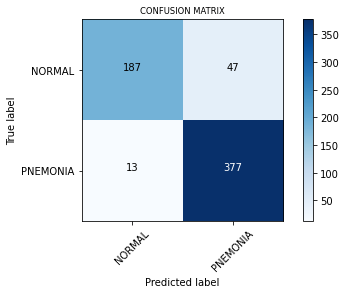

In [28]:
test_data = []
test_labels = []
for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dimensions , img_dimensions))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
data = np.array(test_data)
labels = np.array(test_labels)
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(data)


acc = accuracy_score(labels, np.round(preds))*100
cm = confusion_matrix(labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('\n  PERORMENCE METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print()
print()
Confusion_matrix(cm, classes=['NORMAL', 'PNEMONIA'])
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

print()
print()
print(classification_report(test_labels, np.round(preds), target_names=['normal','pnemonia']))

In [29]:
sample = plt.imread('data/input/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg')
sample = cv2.resize(img, (img_dims, img_dims))
sample = np.dstack([img, img, img])
sample = img.astype('float32') / 255
res = model.predict(np.expand_dims(image.img_to_array(img), axis = 0))  

if res[0][0] > 0.5:
  prediction = 'PNEMONIA DETECTED'
else:
  prediction = 'NORMAL REPORT'
  
print(prediction)

PNEMONIA DETECTED
